Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.2) 비트코인 시세 예측하기

### 바로가기

- [1. 시간정보가 포함된 데이터 살펴보기](#1.-시간정보가-포함된-데이터-살펴보기)
    - [market price 데이터셋의 기본 정보]
    - [시계열 데이터 살펴보기]
- [2. 파이썬 라이브러리를 활용한 시세 예측](#2.-파이썬-라이브러리를-활용한-시세-예측)
    - [Facebook Prophet 활용하기]
    - [ARIMA 모델 활용하기]
- [3. 더 나은 결과를 위한 방법들](#3.-더-나은-결과를-위한-방법들)
    - [상한가와 하한가 선정]
    - [이상치 제거하기]
    - [하이퍼 파라미터 선정하기]
- [재미로 알아보는 내일의 비트코인 시세](#재미로-알아보는-내일의-비트코인-시세)
- [부록 : 선배의 Summary](#부록-:-선배의-Summary)

-----

In [21]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 1. 시간정보가 포함된 데이터 살펴보기

### [market price 데이터셋의 기본 정보]

In [98]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price.csv'
bitcoin_df = pd.read_csv(url, names = ['day', 'price'])

In [99]:
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
day      365 non-null object
price    365 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [100]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


-----

### [시계열 데이터 살펴보기]

In [25]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [26]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


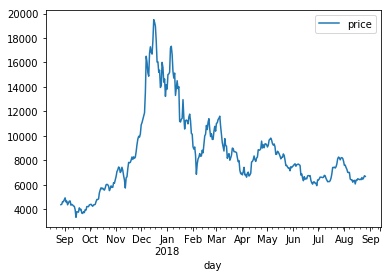

In [27]:
bitcoin_df.plot()
plt.show()

-----

# 2. 파이썬 라이브러리를 활용한 시세 예측

### [Facebook Prophet 활용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 터미널(cmd)에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge fbprophet`
- prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미합니다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.

###### Prophet 모델 학습

In [28]:
from fbprophet import Prophet

In [29]:
bitcoin_df = pd.read_csv(url, names = ['ds', 'y']) # prophet의 input data columns : 'ds', 'y'
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True)
prophet.fit(bitcoin_df)

-----

###### 모델로부터 예측할 기간을 정의하고, 결과를 도출.

In [30]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [31]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,11502.483184,5290.558879,7110.980187,11502.483184,11502.483184,-0.182871,-0.182871,-0.182871,-0.460898,...,-0.000353,-0.000353,-0.000353,-0.277674,-0.277674,-0.277674,0.0,0.0,0.0,6201.010537
366,2018-08-28,11508.971204,5234.452584,7003.071821,11508.971204,11508.971204,-0.182871,-0.182871,-0.182871,-0.466463,...,-0.000301,-0.000301,-0.000301,-0.283291,-0.283291,-0.283291,0.0,0.0,0.0,6140.462902
367,2018-08-29,11515.459225,5150.269448,6855.761747,11515.459225,11515.459225,-0.182871,-0.182871,-0.182871,-0.476878,...,-0.004554,-0.004554,-0.004554,-0.289452,-0.289452,-0.289452,0.0,0.0,0.0,6023.994667
368,2018-08-30,11521.947245,5093.687199,6874.426193,11521.946578,11521.947279,-0.182871,-0.182871,-0.182871,-0.482437,...,-0.003463,-0.003463,-0.003463,-0.296104,-0.296104,-0.296104,0.0,0.0,0.0,5963.332807
369,2018-08-31,11528.435266,5100.881511,6796.897390,11528.432616,11528.436632,-0.182871,-0.182871,-0.182871,-0.485864,...,0.000181,0.000181,0.000181,-0.303174,-0.303174,-0.303174,0.0,0.0,0.0,5927.183789


In [32]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6201.010537,5290.558879,7110.980187
366,2018-08-28,6140.462902,5234.452584,7003.071821
367,2018-08-29,6023.994667,5150.269448,6855.761747
368,2018-08-30,5963.332807,5093.687199,6874.426193
369,2018-08-31,5927.183789,5100.881511,6796.897390


-----

###### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

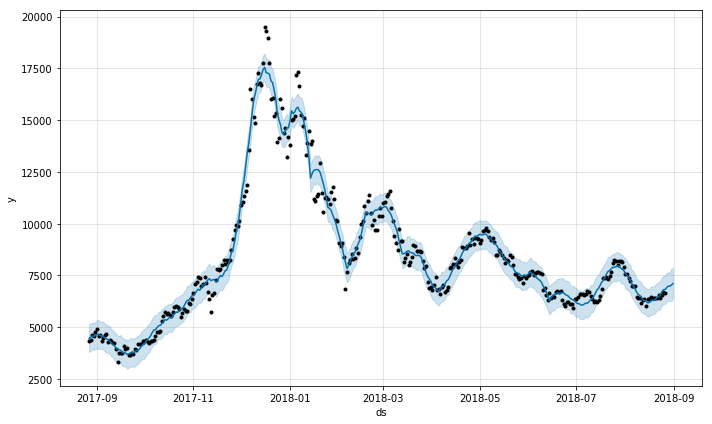

In [58]:
fig1 = prophet.plot(forecast_data)

-----

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

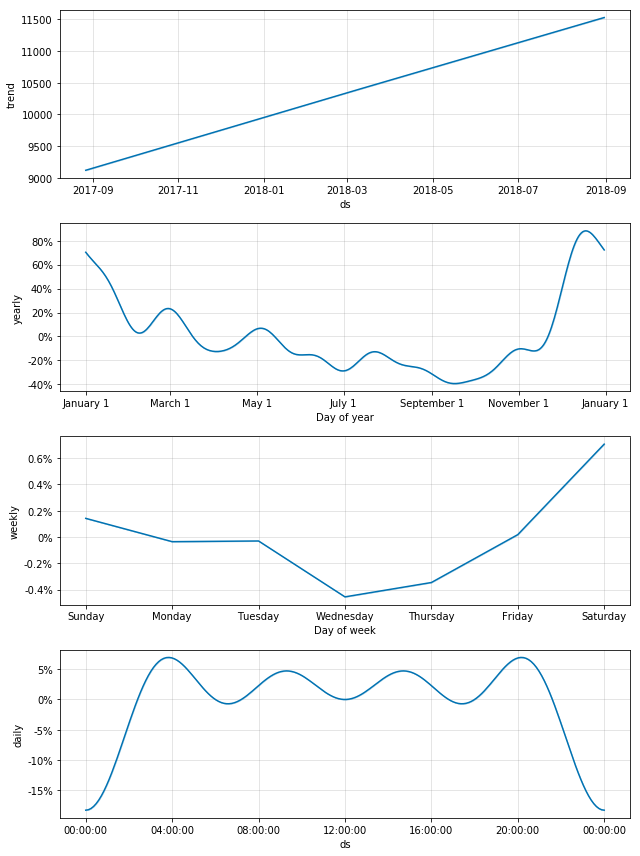

In [34]:
fig2 = prophet.plot_components(forecast_data)

-----

###### 모델의 성능을 살펴봅니다.
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.

In [79]:
y = bitcoin_df.y.values[5:]
y_pred = forecast_data.yhat.values[5:-5]

In [80]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(y, y_pred))
print(rmse)
r2 = r2_score(y, y_pred)
print(r2)

531.1901793082591
0.9728773861945464


In [87]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,702.522189,6199.856763,7596.013249,702.522189,702.522189,10.780826,10.780826,10.780826,8.832530,...,-0.007824,-0.007824,-0.007824,-1.940472,-1.940472,-1.940472,0.0,0.0,0.0,6907.570681
366,2018-08-28,707.216431,6309.231820,7654.583723,707.216431,707.216431,10.780826,10.780826,10.780826,8.885989,...,0.022584,0.022584,0.022584,-1.917422,-1.917422,-1.917422,0.0,0.0,0.0,6991.533665
367,2018-08-29,711.910674,6289.206051,7697.763675,711.910674,712.075053,10.780826,10.780826,10.780826,8.805880,...,-0.063150,-0.063150,-0.063150,-1.911796,-1.911796,-1.911796,0.0,0.0,0.0,6980.910679
368,2018-08-30,716.604916,6342.750628,7757.379848,716.452344,723.795017,10.780826,10.780826,10.780826,8.817042,...,-0.037673,-0.037673,-0.037673,-1.926111,-1.926111,-1.926111,0.0,0.0,0.0,7034.940871
369,2018-08-31,721.299158,6327.109781,7835.805027,714.047126,739.639279,10.780826,10.780826,10.780826,8.859597,...,0.041000,0.041000,0.041000,-1.962229,-1.962229,-1.962229,0.0,0.0,0.0,7111.719117


In [81]:
url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(url, names = ['ds', 'y'])

In [93]:
his = ['2018-08-27 00:00:00', '2018-08-28 00:00:00', '2018-08-29 00:00:00', 
       '2018-08-30 00:00:00', '2018-08-31 00:00:00']
bitcoin_test_df = bitcoin_test_df[bitcoin_test_df['ds'].isin(his)]

In [102]:
bitcoin_test_df.to_csv("market-price-test.csv", index=False, header=False)